In [1]:
# Splines can be used for many quadrotor control problems. In this code example,
# we'll create some splines using Flashlight.

%pylab inline
from pylab import *

# We need to explicitly add the lib folder that contains Flashlight to Python's
# system path for the duration of the Python session. This enables us to import
# Flashlight without needing to copy it into the Python distribution's site-packages
# folder. Modifying the Python system path in this way is not persistent.
#
# This installation-free design is intended to make Flashlight easier to use in
# projects where developers don't neccesarily have acces to the underlying Python
# distribution (e.g., on compute clusters, or on servers that undergraduates use).
import pathutils
pathutils.add_relative_to_current_source_file_path_to_sys_path("../../lib")

import flashlight.splineutils as splineutils
import flashlight.gradientutils as gradientutils

Populating the interactive namespace from numpy and matplotlib
Initializing Flashlight v0.0.1


In [2]:
# We'll begin with creating a 1D scalar spline function. We need to specify
# the value of our 1D scalar function at a few places. We will informally
# refer to the places where we specify the value of our function as keyframes.
# We will compute a spline function that smoothly interpolates the keyframes
# we specify. In this example, t is the independent function parameter, and p
# is the value of the function we're interpolating.

# We specify an array of t values, and a corresponding array of p values. Note
# that the array of t values must have a single column, and the array of p
# values must have a single column for each dimension of the keyframes we want to
# interpolate. In this example, our keyframes are 1D, so our array of p values
# has a single column.
T = matrix([0,1,4,5]).T.A
P = matrix([0,9,1,4]).T.A

In [3]:
# We can compute a so-called "minimum snap" spline as follows.
# 
# In addition to specifying keyframes, we also specify the degree of spline
# we want. In this case, we want degree=7. Flashlight supports degree=5,7,9.
#
# We also specify what derivative we want to minimize across our spline. We do this
# by specifying a lamb array. lamb=[1,0,0,0,0] would minimize the square of the 1st
# derivative across the spline, lamb=[0,1,0,0,0] would minimize the square of the
# 2st derivative across the spline, and so on. The lamb array can also be used to
# specify tradeoffs between minimizing different derivaties. For example,
# lamb=[0.5,0.5,0.0,0.0,0.0] would trade off evenly between minimizing the square of
# the 1st and 2nd derivatives evenly.
#
# In our experience, minimizing the square of the 4th derivative of a 7th degree
# polynomial yields the smoothest and most reasonably bounded control signals for
# quadrotors.
#
# By default, the spline returned by this function will be C4 continuous.
#
# This function returns several objects that are used by Flashlight internally to
# evaluate the spline.
#
# Understanding what these objects are isn't required to use Flashlight correctly,
# but in case you're curious, C is an array that contains the polynomial coefficients
# for each segment of the spline in a normalized 0-to-1 parameter space. By default,
# C also contains the derivative values of the spline segments at the keyframe values,
# also in the normalized 0-to-1 parameter space, since these derivatives are solved
# for jointly with the polynomial coefficients.  T is the array of t values that was
# passed in, but transformed to the correct data type. sd is a dictionary that contains
# a variety of useful information about the spline.
#
# For more details on the underlying optimization problem being solved here, see [1].
#
# References:
#
# [1] Niels Joubert, Mike Roberts, Anh Truong, Floraine Berthouzoz, Pat Hanrahan.
# An Interactive Tool for Designing Quadrotor Camera Shots. ACM Transactions on Graphics
# 35(4) (Proc. SIGGRAPH Asia 2015).
C, T, sd = \
    splineutils.compute_minimum_variation_nonlocal_interpolating_b_spline_coefficients(
        P, T, degree=7, lamb=[0,0,0,1,0])

In [4]:
# We solve for the polynomial coefficients in a normalized parameter space for numerical
# stability. But doing so makes it less straightforward to evaluate the spline. We provide
# the following convenience function for evaluating splines computed with Flashlight.
#
# We specify the C array computed above, the T array computed above, and the number of
# samples we want.
#
# P_eval is the evaluated p values. T_eval is the evaluated t values. dT an array that
# contains the delta between consecutive t values, which we return as a convenience. 
P_eval, T_eval, dT = \
    splineutils.evaluate_minimum_variation_nonlocal_interpolating_b_spline(
        C, T, sd,num_samples=1000)

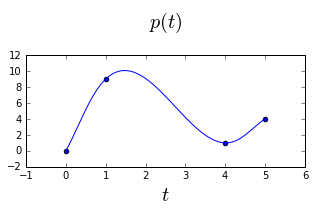

In [16]:
# From here, we are ready to plot the spline.
figsize(5,2);
plot(T_eval[:,0],P_eval[:,0]); scatter(T[:,0],P[:,0]); title("$p(t)$\n", rotation="horizontal", fontsize=20); xlabel("$t$", fontsize=20);

/Users/mike/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


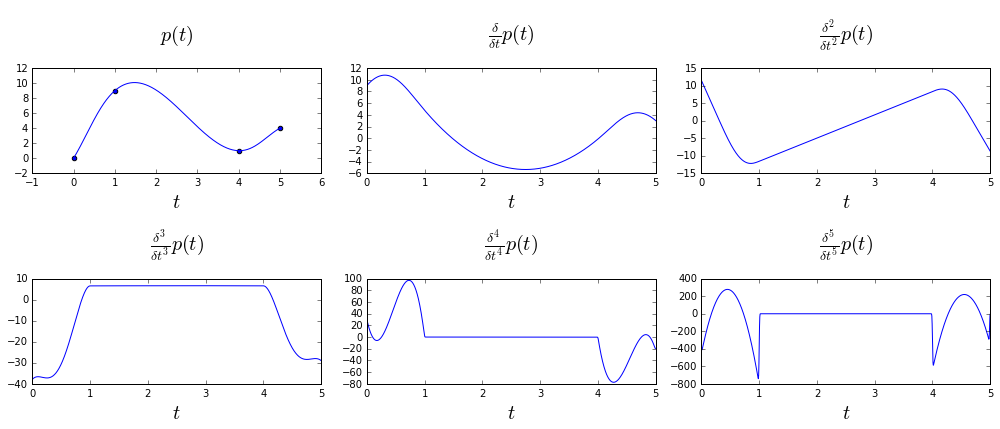

In [17]:
# We can double check that our spline is C4 continuous by plotting its derivatives.
#
# We use our own convenience function to compute the derivatives of our function.
# Our function is conceptually similar to numpy.gradient, except we include some
# extra logic to avoid numerical artifacts at the boundaries. This protects us from
# the pronounced boundary artifacts that occur when computing high-order derivatives
# using finite differences.
#
# More specifically, we extend our function for a few samples at the boundaries using
# a local polynomial approximation at each boundary. Then, we compute all our
# required derivatives using finite differences. Finally, we truncate the resulting
# derivative array back to the correct size, leaving us with an artifact-free array of
# high-order derivatives.
#
# We see on these plots that our interpolated function is continuous up to the 4th
# derivative. In other words, it is C4 continuous.
t  = T_eval[:,0]
pD = gradientutils.gradients_scalar_wrt_scalar_smooth_boundaries(P_eval[:,0], dT[0], max_gradient=5, poly_deg=5)

figsize(14,6)
subplot(231); plot(t,pD[0,:]); scatter(T[:,0],P[:,0]);
title("$p(t)$\n", rotation="horizontal", fontsize=20); xlabel("$t$", fontsize=20);
subplot(232); plot(t,pD[1,:]);
title("$\\frac{\\delta}{\\delta t}p(t)$\n", rotation="horizontal", fontsize=20); xlabel("$t$", fontsize=20);
subplot(233); plot(t,pD[2,:]); title("$\\frac{\\delta^2}{\\delta t^2}p(t)$\n", rotation="horizontal", fontsize=20); xlabel("$t$", fontsize=20);
subplot(234); plot(t,pD[3,:]); title("$\\frac{\\delta^3}{\\delta t^3}p(t)$\n", rotation="horizontal", fontsize=20); xlabel("$t$", fontsize=20);
subplot(235); plot(t,pD[4,:]); title("$\\frac{\\delta^4}{\\delta t^4}p(t)$\n", rotation="horizontal", fontsize=20); xlabel("$t$", fontsize=20);
subplot(236); plot(t,pD[5,:]); title("$\\frac{\\delta^5}{\\delta t^5}p(t)$\n", rotation="horizontal", fontsize=20); xlabel("$t$", fontsize=20);
gcf().tight_layout();